In [1]:
import os
from io import BytesIO
from skimage import io
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import urllib.request
import urllib.parse
import mapbox_vector_tile
import xml.etree.ElementTree as xmlet
import lxml.etree as xmltree
from PIL import Image as plimg
import numpy as np
from owslib.wms import WebMapService
from IPython.display import Image, display
%matplotlib inline


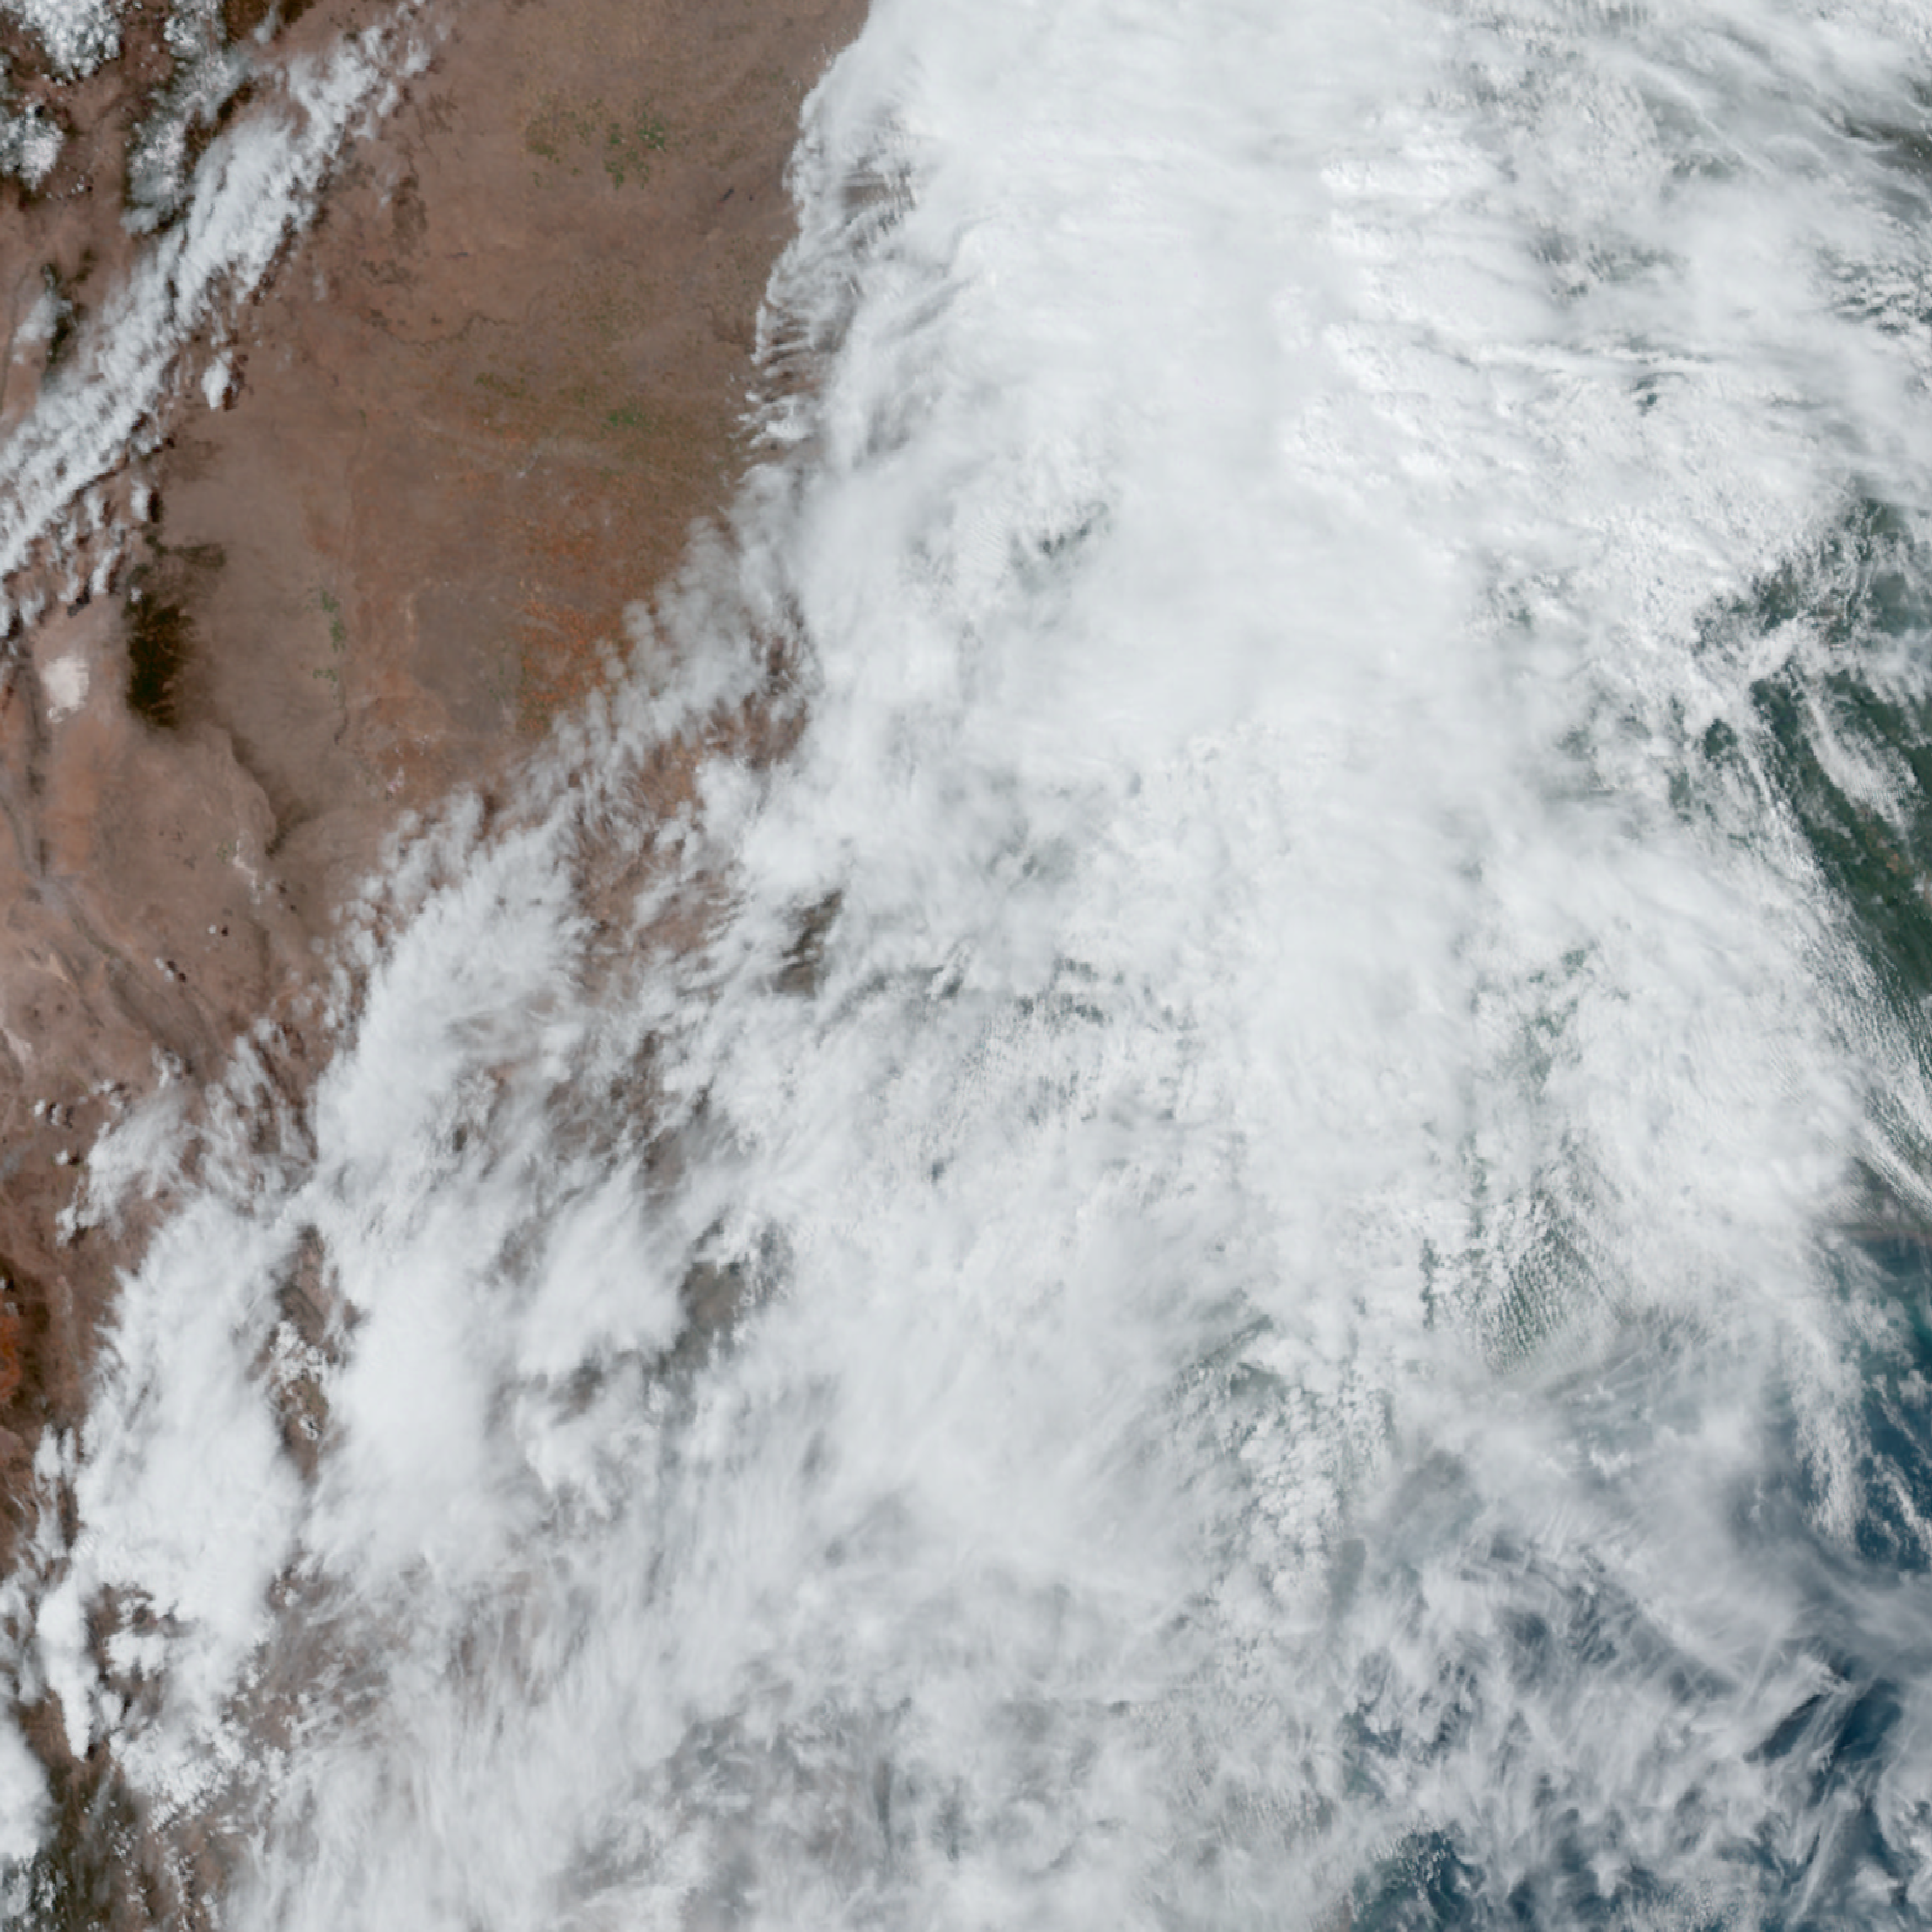

In [100]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.1.1')

# Configure request for MODIS_Terra_CorrectedReflectance_TrueColor
img = wms.getmap(layers=['GOES-East_ABI_GeoColor'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(-106.8,25.75,-93,36.8),  # Bounds
                 size=(5000, 5000),  # Image size
                 time='2023-03-30T20:40:00Z',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# Save output PNG to a file
out = open('/Users/avery/JupyterProjects/NASA/GOES-East_ABI_GeoColor.png', 'wb')
out.write(img.read())
out.close()

# View image
Image('/Users/avery/JupyterProjects/NASA/GOES-East_ABI_GeoColor.png')

In [101]:
import rasterio
from rasterio import features
import geopandas

png_path = '/Users/avery/JupyterProjects/NASA/GOES-East_ABI_GeoColor.png'

output_path = '/Users/avery/JupyterProjects/NASA/repojected.tiff'

def getGeoTiff(png_path, output_path):
  
    bounds = (-106.8,25.75,-93,36.8)
    dataset = rasterio.open(png_path)
    bands = [1,2,3]
    data = dataset.read(bands)
    # Add transforms to out image (georefrencing)
    transform = rasterio.transform.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], 5000, 5000)
    crs = rasterio.crs.CRS({"init": "epsg:4326"})   # 4326  World wide projection (3D)
    
    with rasterio.open(output_path, 'w', driver='GTiff',
                    width=5000, height=5000,
                    count=3, dtype=data.dtype, nodata=0,
                    transform=transform, crs=crs) as dst:
        dst.write(data, indexes=bands)

getGeoTiff(png_path, output_path)

In [92]:
df = geopandas.read_file('/Users/avery/JupyterProjects/NASA/s_22mr22/s_22mr22.shp')
df = df.clip((-106.8,25.75,-93,36.8))
df.to_file('/Users/avery/JupyterProjects/NASA/dataframe.geojson', driver='GeoJSON')   

In [102]:
with rasterio.open('/Users/avery/JupyterProjects/NASA/dataframe.geojson', 'r', driver='GeoJSON') as raster:
    rasterio.features.rasterize(raster, out_shape=(5000,5000),fill=0,out='/Users/avery/JupyterProjects/NASA/repojected.tiff')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "rasterio/_base.pyx", line 308, in rasterio._base.DatasetBase.__init__
  File "rasterio/_base.pyx", line 219, in rasterio._base.open_dataset
  File "rasterio/_err.pyx", line 221, in rasterio._err.exc_wrap_pointer
rasterio._err.CPLE_OpenFailedError: '/Users/avery/JupyterProjects/NASA/dataframe.geojson' not recognized as a supported file format.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/jp/_59yp4z937ngtr9qj1kf2jm80000gn/T/ipykernel_13331/3759543703.py", line 1, in <module>
    with rasterio.open('/Users/avery/JupyterProjects/NASA/dataframe.geojson', 'r', driver='GeoJSON') as raster:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/